> ไฟล์ Python Notebook สำหรับหนังสือ "การเรียนรู้ของเครื่องสำหรับเคมีควอนตัม" โดย รังสิมันต์ เกษแก้ว

> This is a Python notebook for "Machine Learning for Quantum Chemistry" book by Rangsiman Ketkaew

## การคำนวณพลังงานของระบบ Kohn-Sham Electrons ด้วย DFT สำหรับกรณี 1 มิติ

เป้าหมาย: เขียนโค้ดของ Kohn-Sham (KS) Density Functional Theory เพื่อคำนวณพลังงานของระบบที่อิเล็กตรอนไม่มีอันตรกิริยาต่อกัน โดยเราจะใช้แฮมิลโทเนียน (Hamiltonian) ดังต่อไปนี้:

$$\hat{H} = -\frac{1}{2} \frac{d^2}{dx^2} + v(x)$$   โดยที่ $$v(x) = v_{Coul}(x) + v_{LDA}(x) + v_{ext}$$

ดังนั้น Hamiltonian ที่เราจะสร้างกันนั้นคือ 

$$\hat{H} = -\frac{1}{2} \frac{d^2}{dx^2} + v_{Coul}(x) + v_{LDA}(x) + v_{ext}$$

โดยแต่ละเทอมก็คือ:
    1. พลังงานจลน์ (Kinetic Energy)
    2. พลังงานศักย์คูลอมป์ (Coulomb Energy) หรือแรงผลักไฟฟ้าสถิตย์ระหว่างอิเล็กตรอน
    3. พลังงานแลกเปลี่ยน (Exchange Energy) ซึ่งเราการประมาณค่าของความหนาแน่นแบบพื้นที่ (Local Density Approximation) (เราไม่สนใจ Correlation Energy เพราะซับซ้อนเกินไป)
    4. พลังงานภายนอก (External Potential) ซึ่งเราจะใช้ Harmonic Oscillator

สิ่งที่เราต้องทำ
    1. สร้าง Hamiltonian
    2. คำนวณฟังก์ชันคลื่นของ Kohn-Sham (KS Wavefunction)
    3. คำนวณความหนาแน่น (Density)
    4. คำนวณพลังงาน

- อ้างอิงจาก http://dcwww.camd.dtu.dk/~askhl/files/python-dft-exercises.pdf

## นำเข้าไลบรารี่

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style("white")

เริ่มต้นเลยคือเราจะต้องมาเตรียมฟังก์ชันสำหรับการหาอนุพันธ์อันดับที่หนึ่งกับอันดับที่สองกันก่อน เพราะว่าเราจะต้องนำทั้งสองฟังก์ชันนี้ไปใช้งานต่อในการคำนวณหา Hamiltonian ของพลังงานจลน์นั่นเอง

### โอเปอเรเตอร์เชิงอนุพันธ์ (Differential Operator)

- เราจะใช้โอเปอเรเตอร์นี้สำหรับการสร้าง Kinetic Energy Operator 
- ใน section นี้เป้าหมายของเราคือการหาอนุพันธ์ของฟังก์ชันไซน์ (Sin curve) ซึ่งถูกแทนด้วยด้วย real-space grid

ทำการสร้าง Grid

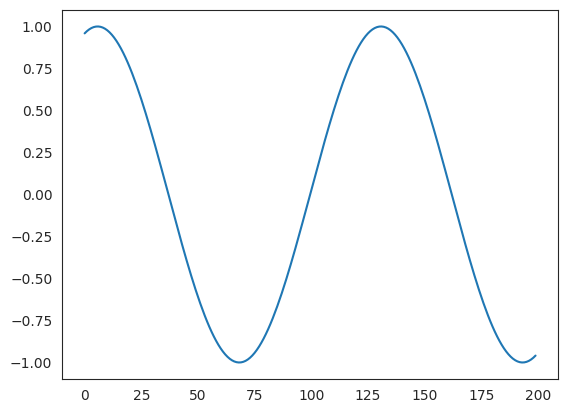

In [3]:
n_grid = 200
x = np.linspace(-5, 5, n_grid)
y = np.sin(x)
plt.plot(y)

#### การหาอนุพันธ์อันดับที่หนึ่ง (First order differentiation)

- นิยามของการหาอนุพันธ์โดยการประมาณค่า:

$$(\frac{dy}{dx})_{i}=\frac{y_{i+1}-{y_{i}}}{h}$$

- นั่นคือ:

$$D_{ij}=\frac{\delta_{i+1,j}-\delta_{i,j}}{h}$$

- เราสามารถเขียนแบบนี้ได้:

$$(\frac{dy}{dx})_{i}=D_{ij} y_{j}$$

หมายเหตุ:
- $\delta_{ij}$ คือ Kronecker Delta
- สำหรับสมการสุดท้ายนั้นเราจะใช้เทคนิค Einstein summation

In [4]:
h = x[1]-x[0]
D = -np.eye(n_grid) + np.diagflat(np.ones(n_grid-1),1)
D = D / h

#### การหาอนุพันธ์อันดับที่สอง (Second oorder differentiation)

- ทำได้แบบเดียวกันกับการหาอนุพันธ์อันดับที่หนึ่ง:

$$D^2_{ij}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{h^2}$$

- โดยสมการด้านบนสามารถเขียนใหม่โดยใช้อนุพันธ์อันดับหนึ่ง $D_{ij}$ ได้ดังนี้ (มีการทำ Transpose ด้วย):

$$D^2_{ij}=-D_{ik}D_{jk}$$

In [5]:
D2 = D.dot(-D.T)
D2[-1,-1] = D2[0,0]

#### ตรวจสอบอนุพันธ์อันดับที่หนึ่งและอันดับที่สองโดยการพลอตดูความต่อเนื่อง

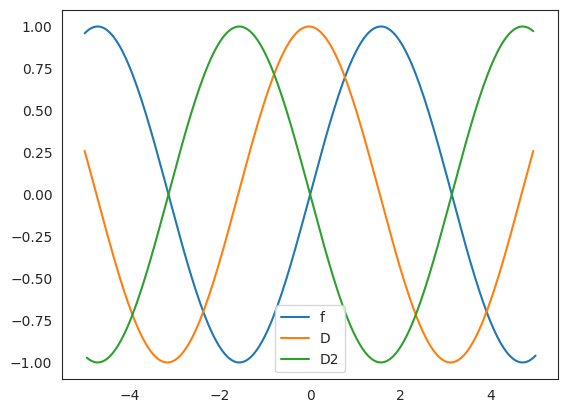

In [6]:
sns.set_style("white")
plt.plot(x,y, label="f")
plt.plot(x[:-1],D.dot(y)[:-1], label="D")
plt.plot(x[1:-1],D2.dot(y)[1:-1], label="D2")
plt.legend()

## 1) พลังงานจลน์ (Kinetic Energy)

- สมการดังต่อไปนี้คือ Hamiltonian Operator ของพลังงานจลน์สำหรับระบบที่อิเล็กตรอนไม่มีอันตรกิริยาต่อกัน (Non-interacting) ซึ่งเราจะสมมติว่าอิเล็กตรอนทั้งหมดนี้อยู่ภายในกล่องซึ่งมีการกำหนดโดยขนาดของ Grid

$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2}$$

- ซึ่งเราสามารถแก้สมการ Kohn-Sham ได้โดยการทำ Diagonalization (เป็นขั้นตอนที่กำหนด Computational Complexity ของ DFT นั่นคือ $\mathcal{O}(n^{3})$

In [7]:
eig_non, psi_non = np.linalg.eigh(-D2/2)

- ทำการพลอต Wavefunction (ค่าพลังงานที่แสดงใน Label คือ Eigenvalue นั่นเอง)

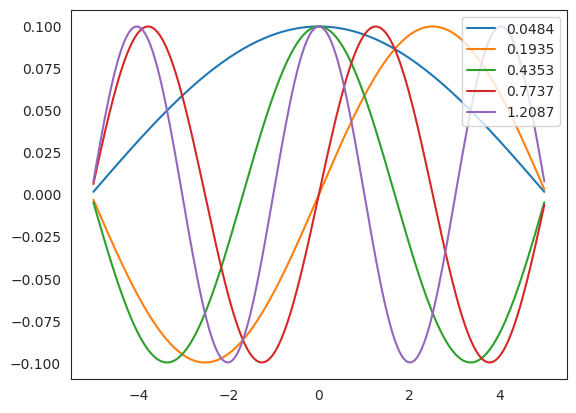

In [8]:
for i in range(5):
    plt.plot(x, psi_non[:,i], label=f"{eig_non[i]:.4f}")
    plt.legend(loc=1)

## 2) พลังงานศักย์ภายนอก (External Potential)

- ลำดับต่อไปคือการพิจารณาศักย์ภายนอก (External Potential) ซึ่งเราสามารถใช้ฟังก์ชัน Harmonic Oscillator ง่าย ๆ ได้
- เช่นในที่นี้เรากำหนดให้ External Potential ก็คือ $v_{ext}=x^2$:
$$\hat{H} = \hat{T} = - \frac{1}{2} \frac{d^2}{dx^2} + x^2$$

- โดยเราสามารถเขียน External Potential ให้อยู่ในรูปของเมทริกซ์ $X$ ได้ดังต่อไปนี้:

In [9]:
X = np.diagflat(x*x)

- และทำการแก้สมการ Kohn-Sham

In [10]:
eig_harm, psi_harm = np.linalg.eigh(-D2/2+X)

- ทำการพลอต

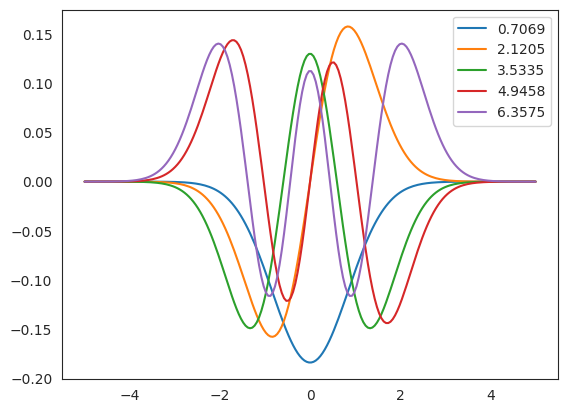

In [11]:
for i in range(5):
    plt.plot(x,psi_harm[:,i], label=f"{eig_harm[i]:.4f}")
    plt.legend(loc=1)

## 3) พลังงานแลกเปลี่ยน (Exchange Energy)

- ลำดับต่อมาคือการคำนวณพลังงานแลกเปลี่ยน (Exchange Energy)
- พิจารณาฟังก์ชันนอลแลกเปลี่ยน (Exchange Functional) สำหรับ Local Density Approximation (LDA) ซึ่งมีสมการที่ง่ายมาก:
    - หมายเหตุ เราไม่สนใจ Correlation Energy เพราะว่าจะซับซ้อนเกินไป

$$ E_X^{LDA}[n] = -\frac{3}{4} \left(\frac{3}{\pi}\right)^{1/3} \int n^{4/3} dx$$

- โดยที่ Potential นั้นสามารถคำนวณได้จากอนุพันธ์ของ Exchange Energy เทียบกับ Density:

$$ v_X^{LDA}[n] = \frac{\partial E_X^{LDA}}{\partial n} = - \left(\frac{3}{\pi}\right)^{1/3} n^{1/3}$$

เราสามารถเขียน Function เพื่อคำนวณ Exchange Energy ได้ดังนี้

In [12]:
def get_exchange(nx,x):
    energy = -3./4.*(3./np.pi)**(1./3.)*integral(x, nx**(4./3.))
    potential = -(3./np.pi)**(1./3.)*nx**(1./3.)
    return energy, potential

## 4) พลังงานคูลอมป์ (Coulomb Potential)

ลำดับต่อมาคือพลังงานคูลอมป์ซึ่งเป็นพลังงานทางไฟฟ้าสถิตย์ (Electrostatic Energy) หรืออาจจะเรียกเรียกว่า Hartree Energy ก็ได้

- อย่างไรก็ตาม ตามทฤษฎีนั้นพลังงานคูลอมป์สำหรับนั้นลู่เข้า (Converged) เฉพาะกรณี 3 มิติเท่านั้น 

$$ E^{3D}_{Coul}=\frac{1}{2}\iint \frac{n(r)n(r')}{\sqrt{(r-r')^2}}drdr'$$

- ดังนั้นในกรณี 1 มิติเราจะต้องทำการโกงนิดหน่อย (เพื่อทำให้พลังงานนั้นลู่เข้า) โดยการปรับสมการ ดังนี้

$$ E^{1D}_{Coul}=\frac{1}{2}\iint \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon}}dxdx'$$

โดยที่ $\varepsilon$ คือคงที่ที่เป็นบวกโดยมีค่าน้อย ๆ ซึ่งทำให้มัน Converged

- ดังนั้นพลังงานศักย์จึงมีสมการดังต่อไปนี้:

$$ v_{Coul}=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon}}dx'$$

- In a matirx expression:
$$E_{Coul} = \frac{1}{2} \frac{n_in_jh^2}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$
$$v_{Coul, i} = \frac{n_jh}{\sqrt{(x_{i}-x_{j})^2+\varepsilon}}$$

In [13]:
def get_coulomb(nx, x, eps=1e-1):
    h = x[1]-x[0]
    energy = np.sum(nx[None,:]*nx[:,None]*h**2/np.sqrt((x[None,:]-x[:,None])**2+eps)/2)
    potential = np.sum(nx[None,:]*h/np.sqrt((x[None,:]-x[:,None])**2+eps), axis=-1)
    return energy, potential

## ความหนาแน่น (Density)

- เนื่องจากว่าเราจะต้องทำการรวม Coulomb Energy และ LDA Exchange โดยที่ทั้งคู่นั้นเป็นฟังก์ชันนอลของความหนาแน่น
- ดังนั้นเราจึงจำเป็นต้องคำนวณความหนาแน่นของอิเล็กตรอน (Electron Density)
- โดยเรามีเงื่อนไขของการทำ Normalization ดังนี้
$$\int \lvert \psi \rvert ^2 dx = 1$$
- ซึ่งเราสามารถเขียนความหนาแน่นให้อยู่ในรูปของผลรวมเชิงเส้นของออร์บิทัลยกกำลังสองได้ ดังนี้ 
$$n(x)=\sum_n f_n \lvert \psi(x) \rvert ^2 $$

โดยที่ $f_n$ คือ Occupation Number (จำนวนอิเล็กตรอนในออร์บิทัลที่ $n$) ซึ่งแต่ละ State นั้นจะมีอิเล็กตรอนที่มีสปินขึ้นและสปินลง โดยใน DFT นั้นเราคำนวณสถานะพื้นของระบบ

- ทำการสร้าง Function สำหรับการ Integrate ซึ่งก็คือการรวมกันนั่นเอง

In [14]:
# integral
def integral(x, y, axis=0):
    dx = x[1]-x[0]
    return np.sum(y*dx, axis=axis)

- กำหนดจำนวนอิเล็กตรอน เช่น 17 ตัว

In [15]:
num_electron = 17

- คำนวณความหนาแน่น

In [16]:
def get_nx(num_electron, psi, x):
    # เริ่มด้วยทำ normalization
    I = integral(x, psi**2, axis=0)
    normed_psi = psi/np.sqrt(I)[None, :]
    
    # Occupation Number
    fn=[2 for _ in range(num_electron//2)]
    if num_electron % 2:
        fn.append(1)

    # Density
    res = np.zeros_like(normed_psi[:,0])
    for ne, psi in zip(fn, normed_psi.T):
        res += ne*(psi**2)
    return res

- พลอตความหนาแน่นโดยใช้พลังงานในรูปต่า ๆ เพื่อเปรียบเทียบกัน

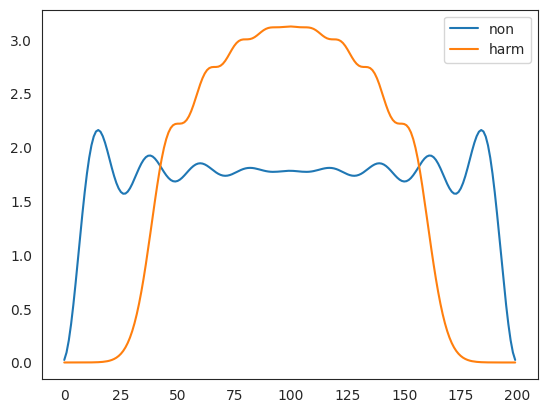

In [17]:
plt.plot(get_nx(num_electron, psi_non, x), label="non")
plt.plot(get_nx(num_electron, psi_harm, x), label="harm")
plt.legend(loc=1)

## มาคำนวณพลังงานของสภานะพื้นกัน! 

เมื่อเราเตรียมองค์ประกอบทุกอย่างพร้อมแล้ว ขั้นตอนต่อไปนี้สำคัญมาก เพราะเราจะนำฟังก์ชันทั้งหมดที่เราได้เขียนไว้มาแก้สมการ Kohn-Sham โดยการวนซ้ำเทียบกับตัวเอง (Self-Consistency)

มีขั้นตอนดังนี้

1. เริ่มต้นด้วยการ Initialize ความหนาแน่น (เราสามารถใช้ค่าคงที่อะไรก็ได้)
2. คำนวณพลังงานศักย์แลกเปลี่ยน (Exchange) และศักย์คูลอมป์ (Coulomb Potential)
3. คำนวณ Hamiltonian
4. แก้สมการ KS เพื่อคำนวณหา Wavefunctions และ Eigenvalues (พลังงาน)
5. ตรวจสอบการลู่เข้า ถ้าไม่ลู่เข้า ให้อัพเดทความหนาแน่นและกลับไปที่ขั้นตอนที่ 2

In [18]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [19]:
max_iter = 1000
energy_tolerance = 1e-5
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [20]:
# Initialize ความหนาแน่น ตัวอย่างเช่นกำหนดให้ค่าเริ่มต้นคือ 0
nx = np.zeros(n_grid)

for i in range(max_iter):
    ex_energy, ex_potential = get_exchange(nx,x)
    ha_energy, ha_potential = get_coulomb(nx,x)
    
    # Hamiltonian
    H = -D2/2+np.diagflat(ex_potential+ha_potential+x*x)
    
    energy, psi= np.linalg.eigh(H)
    
    # เก็บค่าพลังงาน และค่าความแตกต่างของพลังงานระหว่างรอบ
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    # เช็คว่าพลังงานลู่เข้าแล้วหรือยัง
    if abs(energy_diff) < energy_tolerance:
        print("Converged!   :)")
        break
    
    # อัพเดทความหนาแน่น
    nx=get_nx(num_electron, psi, x)
else:
    print("Not Converged   :(")

step: 0     energy: 0.7069     energy_diff: -inf
step: 1     energy: 16.3625    energy_diff: 15.6555321919
step: 2     energy: 13.8021    energy_diff: -2.5603559494
step: 3     energy: 15.3002    energy_diff: 1.4980525863
step: 4     energy: 14.4119    energy_diff: -0.8882287680
step: 5     energy: 14.9470    energy_diff: 0.5350438262
step: 6     energy: 14.6242    energy_diff: -0.3228271880
step: 7     energy: 14.8201    energy_diff: 0.1959328656
step: 8     energy: 14.7011    energy_diff: -0.1190355457
step: 9     energy: 14.7735    energy_diff: 0.0724651058
step: 10    energy: 14.7294    energy_diff: -0.0441312736
step: 11    energy: 14.7563    energy_diff: 0.0268946713
step: 12    energy: 14.7399    energy_diff: -0.0163922405
step: 13    energy: 14.7499    energy_diff: 0.0099933983
step: 14    energy: 14.7438    energy_diff: -0.0060926001
step: 15    energy: 14.7475    energy_diff: 0.0037147279
step: 16    energy: 14.7452    energy_diff: -0.0022649307
step: 17    energy: 14.7466   

- พลอต

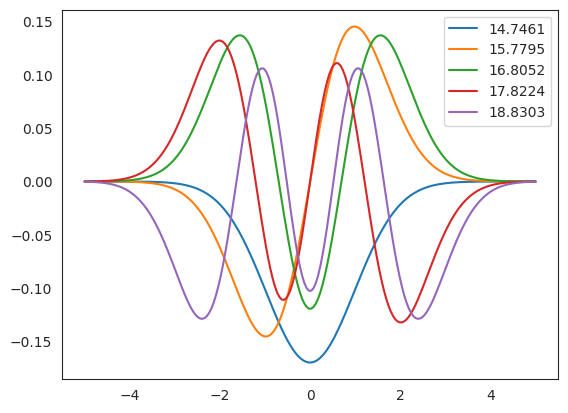

In [21]:
for i in range(5):
    plt.plot(x, psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

- เปรียบเทียบความหนาแน่นสำหรับกรณีที่ไม่มีอันตรกิริยาต่อกัน (Free Particle)

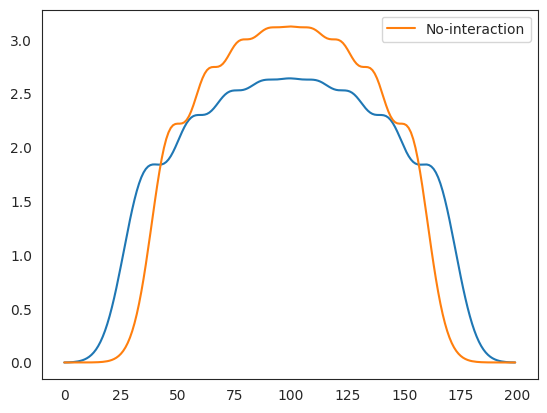

In [22]:
plt.plot(nx)
plt.plot(get_nx(num_electron, psi_harm, x), label="No-interaction")
plt.legend()

#### จบการคำนวณ

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fc3d2631-9178-4bf3-9db3-87923c482dce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>